In [1]:
from autotst.molecule import *
from autotst.reaction import *
from autotst.base import *
from autotst.geometry import *

# To view ase atoms
from ase.visualize import view
import py3Dmol


# `AutoTST_Molecule` objects

To create an `AutoTST_Molecule` object, you simply need to initialize it using the SMILES string associated with the molecule of interest. The 3D geometry of the molecule will automatically be created and you can view using `mol.view_mol()` of the view feature shown below.

In [2]:
mol = AutoTST_Molecule("CCCC")
mol.view_mol()

## So, now we're going to demonstrate how this works on a step by step process

First, we import a variety of things from RDKit, RMG, and ASE

In [3]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.rdMolTransforms import *
import ase
from ase import Atom, Atoms
import rmgpy
from rmgpy.molecule import Molecule
import numpy as np

Next we create an RMG Molecule object using the smiles provided and use functions in RMG to create an RDKit object as well

In [4]:
smiles = "CCCC"
rmg_mol = Molecule(SMILES=smiles)
rmg_mol

In [5]:
def view_mol(mol):
    """
    A method designed to create a 3D figure of the AutoTST_Molecule with py3Dmol from the rdkit_molecule
    """
    mb  = Chem.MolToMolBlock(mol)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb, "sdf")
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

In [6]:
rdkit_mol = rmg_mol.toRDKitMol(removeHs=False)
rdkit.Chem.AllChem.EmbedMolecule(rdkit_mol)
view_mol(rdkit_mol)

Finally, we use the coordinated generated from rdkit to create an ASE Atoms object with idental coordinates

In [7]:
mol_list = AllChem.MolToMolBlock(rdkit_mol).split('\n')
ase_atoms = []
for i, line in enumerate(mol_list):

    if i > 3:
        try:
            atom0, atom1, bond, rest = line
            atom0 = int(atom0)
            atom0 = int(atom1)
            bond = float(bond)

        except ValueError:
            try:
                x, y, z, symbol = line.split()[0:4]
                x = float(x)
                y = float(y)
                z = float(z)
                #print symbol

                ase_atoms.append(Atom(symbol=symbol, position=(x,y,z)))
            except:
                continue

ase_mol = Atoms(ase_atoms)
view(ase_mol, viewer='x3d')

### So, in it's simplicity, an `AutoTST_Molecule` is an object that houses all of the above information (with additional geometric features)

# Now for reactions

`AutoTST_Reaction` objects are created from an RMG `Reaction` object or in the form `r1+r2_p1+p2` in addition to the reaction family of interest. AutoTST currently supports three different reaction families: `H_Abstraction`, `Disproportionation`, and `intro_H_migration`. And you can create an `AutoTST_Reaction` object as shown below.

In [8]:
rxn = AutoTST_Reaction("CCCC+[O]O_[CH2]CCC+OO", "H_Abstraction")
rxn

reaction.py:191 load_databases INFO Loading RMG database from '/Users/nathan/Code/RMG-database/input'
thermo.py:839 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:856 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-database/input/transport/groups...
statmech.py:526 loadGroups INFO Loading frequencies group database from /Users/nathan/Code/RMG-database/input/statmech/groups...
base.py:219 load INFO Loading transitions state family 

<AutoTST Reaction "CCCC+[O]O_[CH2]CCC+OO">

This provides you with an RMG Reaction object that has labeled atoms (atoms that correspond to the active bonds in the reaction). In addition, you can view the 3D guess of the transition state geometry using functions shown below.

In [9]:
rxn.rmg_reaction

In [10]:
rxn.ts.view_ts()

reaction.py:410 get_labels INFO The labled atoms are [2, 7, 0].
reaction.py:355 create_rdkit_ts_geometry INFO Initially embedded molecule
reaction.py:358 create_rdkit_ts_geometry INFO Editing bounds matrix
reaction.py:311 generate_distance_data INFO The distance data is as follows: 
DistanceData(distances={'d12': 1.380401,'d13': 2.530343,'d23': 1.157074,}, uncertainties={'d12': 0.385038,'d13': 0.208449,'d23': 0.303191,}, comment=u'Matched node C/H3/Cs ([<Entry index=118 label="C/H3/Cs">, <Entry index=262 label="Cdj_CdsCs">])\nMatched node OjO ([<Entry index=126 label="C/H2/Cd/Cd">, <Entry index=32 label="OjO">])\n')
reaction.py:426 set_limits INFO For atoms 2 and 7 we have a distance of: 	 1.380401
reaction.py:426 set_limits INFO For atoms 7 and 0 we have a distance of: 	 1.157074
reaction.py:426 set_limits INFO For atoms 2 and 0 we have a distance of: 	 2.530343
reaction.py:487 bm_pre_edit INFO Changing lower limit 2.520343 to 2.457475
reaction.py:487 bm_pre_edit INFO Changing lower l

In [11]:
view(rxn.ts.ase_ts, viewer='x3d')

## Now, to break it down step by step

Again, we import a variety of things from RDKit, RMG, and ASE

In [12]:
import os
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem.rdMolTransforms import *
from rdkit.Chem.rdChemReactions import ChemicalReaction
from rdkit.Chem import AllChem

from rdkit.Chem.Pharm3D import EmbedLib

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction, _isomorphicSpeciesList
from rmgpy.kinetics import PDepArrhenius, PDepKineticsModel
from rmgpy.data.rmg import RMGDatabase

# AutoTST imports
from autotst.base import DistanceData, TransitionStateDepository, TSGroups, TransitionStates
from autotst.molecule import *
from autotst.geometry import *


The reaction string is provided in the form of `r1+r2_p1+p2`, where `r1`, `r2`, `p1`, `p2` are SMILES strings for the reactants and products. In addition, the reaction family is provided as a string of one of the supported families. Using this string, we start by creating `AutoTST_Molecule` objects for the reactants and products

In [13]:
reaction_string = "CCCC+[O]O_[CH2]CCC+OO"
family_string = "H_Abstraction"

In [14]:
reactants, products = reaction_string.split("_")

if "+" in reactants:
    reactants = reactants.split("+")

if "+" in products:
    products = products.split("+")

reactant_mols = []
product_mols = []

for reactant in reactants:
    reactant_mols.append(AutoTST_Molecule(reactant))

for product in products:
    product_mols.append(AutoTST_Molecule(product))

reactant_mols, product_mols

([<AutoTST Molecule "CCCC">, <AutoTST Molecule "[O]O">],
 [<AutoTST Molecule "[CH2]CCC">, <AutoTST Molecule "OO">])

Next, we load a `RMGDatabase` object. This will provide us with the proper atom labeling for the reactants and products.

In [15]:
rmg_database = RMGDatabase()
database_path = rmgpy.settings['database.directory']
rmg_database.load(database_path,
                 kineticsFamilies=[family_string],
                 transportLibraries=[],
                 reactionLibraries=[],
                 seedMechanisms=[],
                 thermoLibraries=['primaryThermoLibrary', 'thermo_DFT_CCSDTF12_BAC', 'CBS_QB3_1dHR' ],
                 solvation=False,
                 )

family = rmg_database.kinetics.families[family_string]
family

rmg.py:72 __init__ WARNING Should only make one instance of RMGDatabase because it's stored as a module-level variable!
rmg.py:73 __init__ WARNING Unexpected behaviour may result!
thermo.py:839 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:856 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-database/input/transport/groups...
statmech.py:526 loadGroups INFO Loading frequencies group database from /Users/nathan/Code/RMG-database/in

<ReactionFamily "H_Abstraction">

Next we load the `TransitionState` database object for the corresponding reaction family

In [16]:
ts_database = TransitionStates()
path = os.path.join("../database/", family_string)
global_context = { '__builtins__': None }
local_context={'DistanceData': DistanceData}
family = rmg_database.kinetics.families[family_string]
ts_database.family = family
ts_database.load(path, local_context, global_context)
ts_database

base.py:219 load INFO Loading transitions state family groups from ../database/H_Abstraction/TS_groups.py


<autotst.base.TransitionStates instance at 0x181c6a1a70>

Following this, we label the reactants and products using a `ReactionFamily` object from the `RMGDatabase` object.

In [17]:
rmg_reactants = []
rmg_products = []

for reactant_mol in reactant_mols:
    rmg_reactants.append(reactant_mol.rmg_molecule)

for product_mol in product_mols:
    rmg_products.append(product_mol.rmg_molecule)
    
    
labeled_r, labeled_p = family.getLabeledReactantsAndProducts(rmg_reactants, rmg_products)
test_reaction = Reaction(reactants=labeled_r, products=labeled_p, reversible=True)
test_reaction

Now, we ensure the reaction of interest matches the family that was provided. We do this by generating a list of reactions from the reactants and products provided and assert that reaction of interest is isomorphic to one of the reactions in the list of reactions. We then set the labeled reactants and products to the `TemplateReaction` object generated by the `RMGDatabase`.

In [18]:
reaction_list = rmg_database.kinetics.generate_reactions_from_families(
            rmg_reactants,
            rmg_products)

assert reaction_list

for rmg_reaction in reaction_list:
    if rmg_reaction.isIsomorphic(test_reaction):
        if (_isomorphicSpeciesList(rmg_reaction.reactants, test_reaction.reactants)) and (_isomorphicSpeciesList(rmg_reaction.products, test_reaction.products)):
            rmg_reaction.reactants = test_reaction.reactants
            rmg_reaction.products = test_reaction.products

        elif (_isomorphicSpeciesList(rmg_reaction.products, test_reaction.reactants)) and (_isomorphicSpeciesList(rmg_reaction.reactants, test_reaction.products)):
            rmg_reaction.products = test_reaction.reactants
            rmg_reaction.reactants = test_reaction.products
            
        
            
print rmg_reaction.family
rmg_reaction

H_Abstraction


In [19]:
type(rmg_reaction)

rmgpy.data.kinetics.family.TemplateReaction

Following this, we use our group tree and the `TransitionStates` database object to estimate the key distances for the labeled atoms.

In [20]:
distance_data = ts_database.groups.estimateDistancesUsingGroupAdditivity(rmg_reaction)
distance_data

DistanceData(distances={'d12': 1.380401,'d13': 2.530343,'d23': 1.157074,}, uncertainties={'d12': 0.385038,'d13': 0.208449,'d23': 0.303191,}, comment=u'Matched node C/H3/Cs ([<Entry index=118 label="C/H3/Cs">, <Entry index=262 label="Cdj_CdsCs">])\nMatched node OjO ([<Entry index=126 label="C/H2/Cd/Cd">, <Entry index=32 label="OjO">])\n')

Once we have this data, we can create 3D geometries of the transition state. First, we merge the reactant and product species into one RMG molecule object and identify the indicies of the labeled atoms.

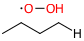

In [21]:
merged_reacts = None
merged_prods = None

if len(rmg_reaction.reactants) == 2:
    merged_reacts = Molecule.merge(rmg_reaction.reactants[0],
                                   rmg_reaction.reactants[1])

if len(rmg_reaction.products) == 2:
    merged_prods = Molecule.merge(rmg_reaction.products[0],
                                   rmg_reaction.products[1])
    
merged_reacts.updateMultiplicity()
merged_reacts

In [22]:
for i, atom in enumerate(merged_reacts.atoms):
    if atom.label == "*1":
        lbl1 = i
    if atom.label == "*2":
        lbl2 = i
    if atom.label == "*3":
        lbl3 = i
labels = [lbl1, lbl2, lbl3]
atomMatch = ((lbl1,), (lbl2,), (lbl3,))
labels

[2, 7, 0]

Now, we use the RMG molecule to generate an RDKit molecule with identical indexing and use RDKit to generate independent 3D geometries of the merged reactants. This will show the reactants overlapping - this is not an issue, we'll address this further down this notebook. 

In [23]:
combined = merged_reacts.toRDKitMol(removeHs=False)
Chem.rdDistGeom.EmbedMolecule(combined)
view_mol(combined)

Now, we obtain the bounds matrix of the RDKit molecule object. The bounds matrix describes the distances between all atoms in the RDKit molecule with minimul and maximum distance thresholds. 

In [24]:
bm = rdkit.Chem.rdDistGeom.GetMoleculeBoundsMatrix(combined)
bm

array([[0.00000000e+00, 1.32600000e+00, 1.00000000e+03, 1.00000000e+03,
        1.00000000e+03, 1.00000000e+03, 1.93274314e+00, 1.00000000e+03,
        1.00000000e+03, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03,
        1.00000000e+03, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03,
        1.00000000e+03],
       [1.30600000e+00, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03,
        1.00000000e+03, 1.00000000e+03, 1.00025420e+00, 1.00000000e+03,
        1.00000000e+03, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03,
        1.00000000e+03, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03,
        1.00000000e+03],
       [3.65000000e+00, 3.65000000e+00, 0.00000000e+00, 3.81071948e+00,
        1.52400000e+00, 2.51279063e+00, 1.00000000e+03, 1.11940079e+00,
        1.11940079e+00, 1.11940079e+00, 1.00000000e+03, 1.00000000e+03,
        1.00000000e+03, 2.19506659e+00, 2.19506659e+00, 3.43890609e+00,
        3.43890609e+00],
       [3.65000000e+00, 3.65000000e+00, 2.52476717e+00, 0.000

Next, we use the following cells to edit the bounds matrix using the distance data that we obtained from above. In addition to this, we change specific values of the matrix and perform triangle smoothing so that we do not provide unreasonable geometries.

In [25]:
def set_limits(bm, lbl1, lbl2, value, uncertainty):
    """
    A method to set the limits of a particular distance between two atoms

    :param bm: an array of arrays corresponding to the bounds matrix
    :param lbl1: the label of one atom
    :param lbl2: the label of another atom
    :param value: the distance from a distance data object (float)
    :param uncertainty: the uncertainty of the `value` distance (float)
    :return bm: an array of arrays corresponding to the edited bounds matrix
    """
    if lbl1 > lbl2:
        bm[lbl2][lbl1] = value + uncertainty / 2
        bm[lbl1][lbl2] = max(0, value - uncertainty / 2)
    else:
        bm[lbl2][lbl1] = max(0, value - uncertainty / 2)
        bm[lbl1][lbl2] = value + uncertainty / 2

    return bm

In [26]:
lbl1, lbl2, lbl3 = labels

sect = [] #rename for future
for atom in merged_reacts.split()[1].atoms: sect.append(atom.sortingLabel)

uncertainties = {'d12': 0.02, 'd13': 0.02, 'd23': 0.02}  # distanceData.uncertainties or {'d12':0.1, 'd13':0.1, 'd23':0.1 } # default if uncertainty is None
bm = set_limits(bm, lbl1, lbl2, distance_data.distances['d12'], uncertainties['d12'])
bm = set_limits(bm, lbl2, lbl3, distance_data.distances['d23'], uncertainties['d23'])
bm = set_limits(bm, lbl1, lbl3, distance_data.distances['d13'], uncertainties['d13'])

In [27]:
others = range(len(bm))
for idx in sect: others.remove(idx)

for i in range(len(bm)):#sect:
    for j in range(i):#others:
        if i<j: continue
        for k in range(len(bm)):
            if k==i or k==j or i==j: continue
            Uik = bm[i,k] if k>i else bm[k,i]
            Ukj = bm[j,k] if k>j else bm[k,j]

            maxLij = Uik + Ukj - 0.1
            if bm[i,j] >  maxLij:
                logging.info("Changing lower limit {0} to {1}".format(bm[i, j], maxLij))
                bm[i,j] = maxLij


<ipython-input-27-b1f14356e19b>:14 <module> INFO Changing lower limit 2.520343 to 2.457475
<ipython-input-27-b1f14356e19b>:14 <module> INFO Changing lower limit 3.65 to 3.26214059416
<ipython-input-27-b1f14356e19b>:14 <module> INFO Changing lower limit 2.9 to 2.393074


In [28]:
rdkit.DistanceGeometry.DoTriangleSmoothing(bm)
# Triangle smoothing is??

True

In [29]:
bm

array([[0.        , 1.326     , 2.540343  , 5.87493122, 3.36214059,
        4.60598009, 1.93274314, 1.167074  , 3.01903958, 3.01903958,
        6.80104669, 6.80104669, 6.80104669, 4.242455  , 4.242455  ,
        5.55720719, 5.55720719],
       [1.306     , 0.        , 3.866343  , 7.20093122, 4.68814059,
        5.93198009, 1.0002542 , 2.493074  , 4.34503958, 4.34503958,
        8.12704669, 8.12704669, 8.12704669, 5.568455  , 5.568455  ,
        6.88320719, 6.88320719],
       [2.457475  , 3.65      , 0.        , 3.81071948, 1.524     ,
        2.51279063, 4.47308614, 1.390401  , 1.11940079, 1.11940079,
        4.70785722, 4.70785722, 4.70785722, 2.19506659, 2.19506659,
        3.43890609, 3.43890609],
       [3.65      , 3.65      , 2.52476717, 0.        , 2.51279063,
        1.524     , 7.80767436, 4.70785722, 4.70785722, 4.70785722,
        1.11940079, 1.11940079, 1.11940079, 3.43890609, 3.43890609,
        2.19506659, 2.19506659],
       [3.26214059, 3.65      , 1.504     , 2.432790

Following this, we use the edited bounds matrix to regenerate the 3D structure of the transition state. In addition, we do a force field optimization of the transition state to provide a more reasonable guess.

In [30]:
combined.RemoveAllConformers()
for i in range(0, 1000):
    try:
        EmbedLib.EmbedMol(combined, bm, atomMatch=atomMatch)
        break
    except ValueError:
        x = 3
        logging.info("RDKit failed to embed on attempt {0} of {1}".format(i + 1, 1000))
        # What to do next (what if they all fail?) !!!!!
    except RuntimeError:
        logging.info("RDKit failed to embed.")
else:
    logging.error("RDKit failed all attempts to embed")
    
for i in range(len(combined.GetConformers())):
    combined.GetConformers()[i].SetId(i)
    
view_mol(combined)

In [31]:
energy = 0.0
minEid = 0;
lowestE = 9.999999e99;  # start with a very high number, which would never be reached
crude = Chem.Mol(combined.ToBinary())

for conf in combined.GetConformers():
    if bm is None:
        AllChem.UFFOptimizeMolecule(combined, confId=conf.GetId())
        energy = AllChem.UFFGetMoleculeForceField(combined, confId=conf.GetId()).CalcEnergy()
    else:
        eBefore, energy = EmbedLib.OptimizeMol(combined, bm, atomMatches=atomMatch,
                                               forceConstant=100000.0)

    if energy < lowestE:
        minEid = conf.GetId()
        lowestE = energy
        
view_mol(combined)

We now create an ASE Atoms object that mirrors the RDKit molecule object.

In [32]:
mol_list = AllChem.MolToMolBlock(combined).split('\n')
ase_atoms = []
for i, line in enumerate(mol_list):

    if i > 3:

        try:
            atom0, atom1, bond, rest = line
            atom0 = int(atom0)
            atom0 = int(atom1)
            bond = float(bond)

        except ValueError:
            try:
                x, y, z, symbol = line.split()[0:4]
                x = float(x)
                y = float(y)
                z = float(z)
                # print symbol

                ase_atoms.append(Atom(symbol=symbol, position=(x, y, z)))

            except:
                continue

ase_ts = Atoms(ase_atoms)
view(ase_ts, viewer='x3d')

## And that's all there is to providing you with your transition state geometry guess!

Following this, we perform a series of partial optimizations using `autotst.calculator` objects.